# Hourly Time Series Forecasting using XGBoost

[If you haven't already first check out my previous notebook forecasting on the same data using Prophet](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-prophet)

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'statsmodels'

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [ ]:
df = pd.read_csv('adolescent#009.csv', index_col=[0], parse_dates=[0])
df = df.iloc[:, [0]]
print(df)

                             BG
Time                           
2023-12-13 00:00:00  137.970000
2023-12-13 00:03:00  137.970000
2023-12-13 00:06:00  137.970000
2023-12-13 00:09:00  137.970000
2023-12-13 00:12:00  137.970000
...                         ...
2023-12-27 23:48:00   82.233942
2023-12-27 23:51:00   81.434409
2023-12-27 23:54:00   80.713727
2023-12-27 23:57:00   80.070580
2023-12-28 00:00:00   79.501210

[7201 rows x 1 columns]


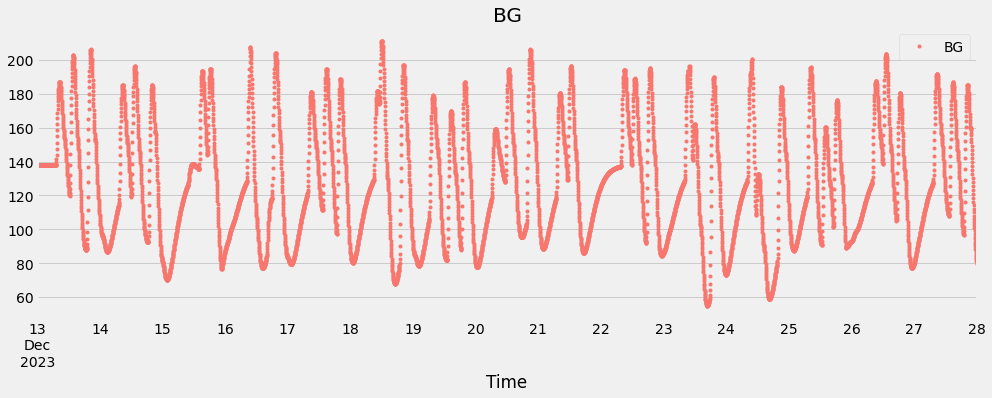

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='BG')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [ ]:
split_date = '2023-12-27 22:00:00'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

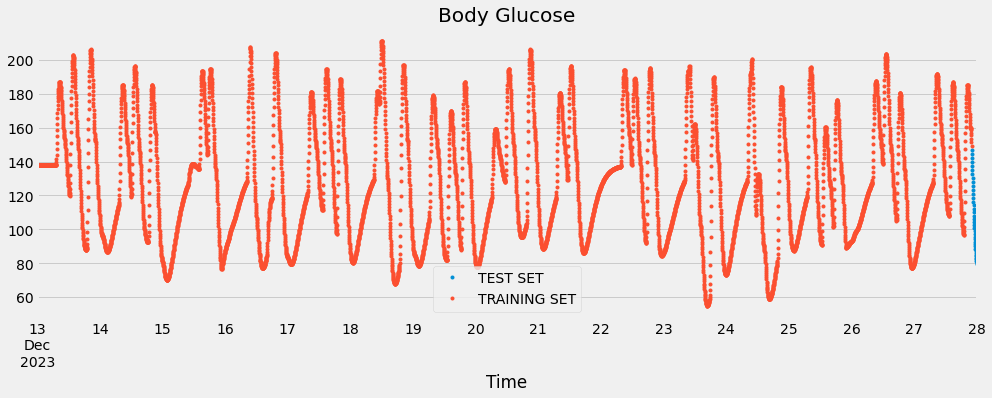

In [ ]:
_ = df_test \
    .rename(columns={'BG': 'TEST SET'}) \
    .join(df_train.rename(columns={'BG': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Body Glucose', style='.')

# Create Time Series Features

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['minute'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','minute']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(df_train, label='BG')
X_test, y_test = create_features(df_test, label='BG')

In [ ]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,minute
Time,,,,,,,,
2023-12-13 00:00:00,0,2,4,12,2023,347,13,0
2023-12-13 00:03:00,0,2,4,12,2023,347,13,3
2023-12-13 00:06:00,0,2,4,12,2023,347,13,6
2023-12-13 00:09:00,0,2,4,12,2023,347,13,9
2023-12-13 00:12:00,0,2,4,12,2023,347,13,12
...,...,...,...,...,...,...,...,...
2023-12-27 21:48:00,21,2,4,12,2023,361,27,48
2023-12-27 21:51:00,21,2,4,12,2023,361,27,51
2023-12-27 21:54:00,21,2,4,12,2023,361,27,54


In [ ]:
y_train

Time
2023-12-13 00:00:00    137.970000
2023-12-13 00:03:00    137.970000
2023-12-13 00:06:00    137.970000
2023-12-13 00:09:00    137.970000
2023-12-13 00:12:00    137.970000
                          ...    
2023-12-27 21:48:00    157.113478
2023-12-27 21:51:00    155.407667
2023-12-27 21:54:00    153.455035
2023-12-27 21:57:00    151.328759
2023-12-27 22:00:00    149.085007
Name: BG, Length: 7161, dtype: float64

# Create XGBoost Model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, gamma = 0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

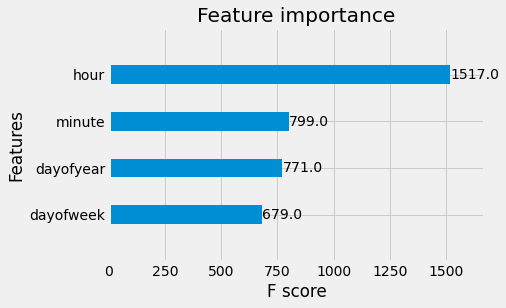

In [ ]:
_ = plot_importance(reg, height=0.4)

# Forecast on Test Set

In [ ]:
df_test['BG_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([df_test, df_train], sort=False)

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

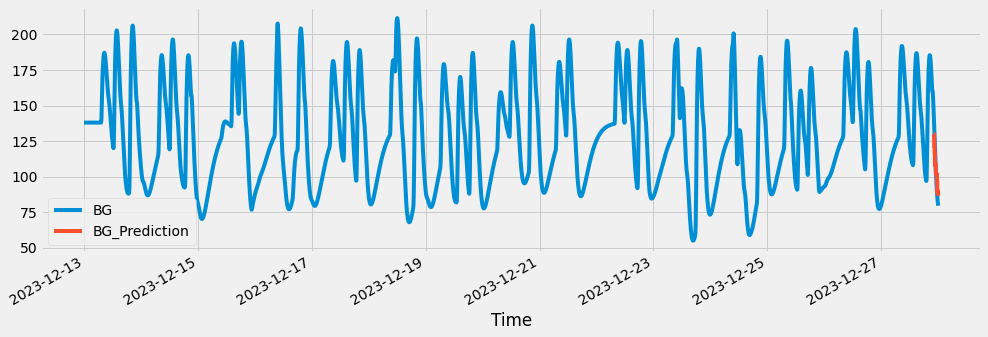

In [ ]:
_ = pjme_all[['BG','BG_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

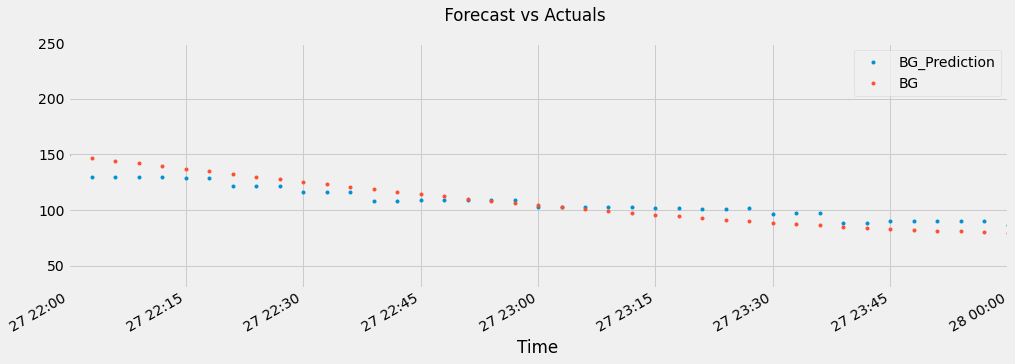

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['BG_Prediction','BG']].plot(ax=ax,
                                              style=['.','.'])
ax.set_xbound(lower='2023-12-27 22:00:00', upper='2023-12-28 00:00:00')
ax.set_ylim(30, 250)
plot = plt.suptitle(' Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [ ]:
mean_squared_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

64.88599103126205

In [ ]:
mean_absolute_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

7.162456440767963

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=df_test['BG'],
                   y_pred=df_test['BG_Prediction'])

6.831916539376219

# Look at Worst and Best Predicted Days

In [ ]:
df_test['error'] = df_test['BG'] - df_test['BG_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['BG','BG_Prediction','error','abs_error']]

In [ ]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

BG  BG_Prediction     error  abs_error
year month dayofmonth                                                
2023 12    28           79.501210      86.500710 -6.999499   6.999499
           27          107.599287     107.398697  0.200585   7.166635

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

BG  BG_Prediction     error  abs_error
year month dayofmonth                                                
2023 12    27          107.599287     107.398697  0.200585   7.166635
           28           79.501210      86.500710 -6.999499   6.999499

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

BG  BG_Prediction     error  abs_error
year month dayofmonth                                                
2023 12    28           79.501210      86.500710 -6.999499   6.999499
           27          107.599287     107.398697  0.200585   7.166635

# Plotting some best/worst predicted days

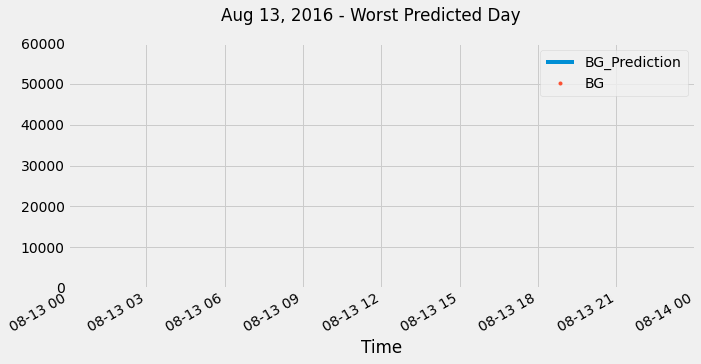

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['BG_Prediction','BG']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

KeyError: "None of [Index(['MW_Prediction', 'PJME_MW'], dtype='object')] are in the [columns]"

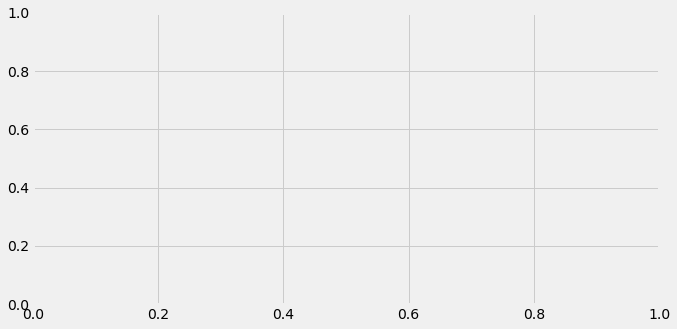

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

KeyError: "None of [Index(['MW_Prediction', 'PJME_MW'], dtype='object')] are in the [columns]"

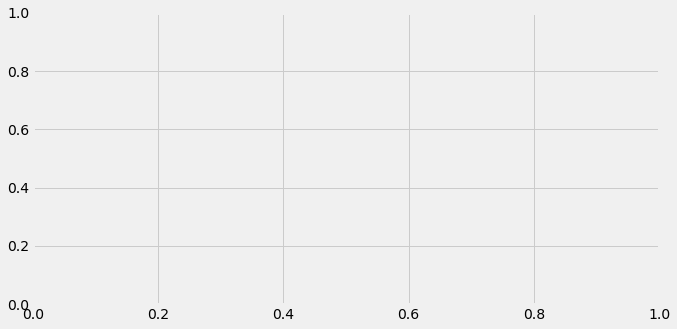

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.